# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import gensim
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# Import News categorization dataset
df = pd.read_json("/kaggle/input/news-category-dataset/News_Category_Dataset_v2.json", lines = True)

In [4]:
# Extract two top categories out of the entire list
df_pol_wel = df.loc[(df['category'] == 'POLITICS') | (df['category'] == 'WELLNESS')][['category', 'headline']]

In [5]:
# Reset index to correct teh index element
df_pol_wel.reset_index(inplace = True, drop = True)

In [6]:
def label_encoder(x):
    if x == 'POLITICS':
        return 0
    else:
        return 1
    
df_pol_wel['category'] = df_pol_wel['category'].apply(lambda x: label_encoder(x))

In [7]:
# Split dataset into train and test for model training and evaluation
X = df_pol_wel['headline']
y = df_pol_wel['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state = 333)
X_train.head()

45430     You Live in Your Body, Not Your Doctor -- Part I
33559    Chemicals in Everyday Products Can Ruin Your H...
5270                   We Are Two Emotional Nations at War
16056    These Nuclear Launch Officers Are Scared By Th...
48923    Walking Could Help To Decrease Depression, Rev...
Name: headline, dtype: object

In [8]:
# Convert into tokens for futher analysis
vect = CountVectorizer(min_df=20, max_df=0.2, stop_words='english', token_pattern='(?u)\\b\\w\\w\\w+\\b')
X_trained = vect.fit_transform(X_train)

# min_df: minimum document frequency above which the tokens will be rejected
# max_df: maximum document frequency below which the token will be rejected
# stop_words: language for which the stop words will be used
# token_pattern: manualy fed token separater

In [9]:
# Convert into Bag-of-words from sparse vector
corpus = gensim.matutils.Sparse2Corpus(X_trained, documents_columns=False)

# Fetch the vocabulary details out of the Count Vector 
word_to_label = dict((v, k) for k, v in vect.vocabulary_.items())

# Model trainging
ldamodel = gensim.models.LdaMulticore(corpus=corpus, id2word=word_to_label, passes=15,
                                               random_state=5, num_topics=2, workers=3)

# corpus: the list of words from BoW model
# id2word: label to word mapping as words have been converted into numerics
# passes: number of iterations
# random_state: to avoid getting different results everytime the model runs
# num_topics: number of topics you want to extract 
# workers: the number of parallelized text

In [10]:
# Print the topics and its composition in terms of probabilites

for idx, topic in ldamodel.print_topics(-1):  # To get the list of extracted topics in the text
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.066*"trump" + 0.022*"donald" + 0.012*"gop" + 0.012*"obama" + 0.009*"says" + 0.009*"house" + 0.007*"white" + 0.006*"court" + 0.006*"senate" + 0.006*"republicans"


Topic: 1 
Words: 0.017*"new" + 0.017*"clinton" + 0.013*"hillary" + 0.010*"study" + 0.009*"health" + 0.008*"life" + 0.008*"day" + 0.007*"cancer" + 0.006*"make" + 0.006*"time"




In [11]:
# prediction for test data

def topic_prediction(my_document):
    string_input = [my_document]
    X = vect.transform(string_input)
    corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
    output = list(ldamodel[corpus])[0]
    topics = sorted(output,key=lambda x:x[1],reverse=True)
    return topics[0][0]
 
topic_prediction(df_pol_wel.headline[0])

0

In [36]:
def train_LDA(n, y, x, z, a):
    train_accuracy = []
    test_accuracy= []
    for i in tqdm(range(1,n)):
        train_prediction = []
        test_prediction = []
        
        ldamodel = gensim.models.LdaMulticore(corpus=corpus, id2word=word_to_label, passes=n,
                                               random_state=5, num_topics=2, workers=3)
        
        for k in tqdm(x): 
            train_prediction.append(topic_prediction(k))
        train_accuracy.append(accuracy_score(y, train_prediction))
        
        for j in tqdm(z):
            test_prediction.append(topic_prediction(j))
        test_accuracy.append(accuracy_score(a, test_prediction))
        
    return train_accuracy, test_accuracy

In [43]:
train_acc, test_acc = train_LDA(25, y_train, X_train, X_test, y_test)

100%|██████████| 40452/40452 [00:16<00:00, 2461.50it/s]

100%|██████████| 40452/40452 [00:15<00:00, 2554.38it/s]

100%|██████████| 40452/40452 [00:15<00:00, 2666.93it/s]

100%|██████████| 40452/40452 [00:16<00:00, 2502.45it/s]

100%|██████████| 40452/40452 [00:15<00:00, 2578.25it/s]

100%|██████████| 40452/40452 [00:16<00:00, 2468.10it/s]

100%|██████████| 40452/40452 [00:16<00:00, 2429.54it/s]

100%|██████████| 40452/40452 [00:15<00:00, 2528.86it/s]

100%|██████████| 40452/40452 [00:16<00:00, 2475.32it/s]

100%|██████████| 40452/40452 [00:16<00:00, 2485.49it/s]

100%|██████████| 40452/40452 [00:15<00:00, 2563.98it/s]

100%|██████████| 40452/40452 [00:16<00:00, 2518.13it/s]

100%|██████████| 40452/40452 [00:16<00:00, 2405.16it/s]

100%|██████████| 40452/40452 [00:16<00:00, 2493.45it/s]

100%|██████████| 40452/40452 [00:16<00:00, 2495.25it/s]

100%|██████████| 40452/40452 [00:16<00:00, 2431.62it/s]

100%|██████████| 40452/40452 [00:16<00:00, 2483.08it/s]

100%|██████████| 40452/40452 [0

<AxesSubplot:>

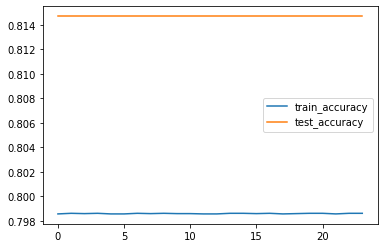

In [44]:
p = pd.DataFrame()
p['train_accuracy']  = train_acc
p['test_accuracy'] = test_acc
p.plot()

In [39]:
train_acc

[0.7986008108375359,
 0.7985760901809552,
 0.7986008108375359,
 0.7985760901809552,
 0.7986008108375359,
 0.7985760901809552,
 0.7986008108375359,
 0.7986255314941165,
 0.7985266488677939]

In [41]:
test_acc

[0.8147122800079099,
 0.8147122800079099,
 0.8147122800079099,
 0.8147122800079099,
 0.8147122800079099,
 0.8147122800079099,
 0.8147122800079099,
 0.8147122800079099,
 0.8147122800079099]

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: No module named 'pyLDAvis.gensim'